# Training your own Classifier

We will use a tecnique of transfering learning, in this case we will use the model **EfficientNetB0**, because it's lower than 100MB (github accept to push) and has a good score.

There are more based models: https://keras.io/api/applications/

### Install Modules

In [1]:
# pip install -r requirements.txt

### Importing Modules

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import zipfile

In [6]:
# Check TensorFlow version
print(tf.__version__)

2.5.0


### Transfer Learning and Model Reuse

# EfficientNetB0

In [7]:
# Load the base model: EfficientNetB0
# We use pre-trained weights from ImageNet and exclude the top layers.
# This means we are using the convolutional base, which captures general features,
# while we will add our own fully connected layers for our specific task.
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',            # Load weights pre-trained on ImageNet
    include_top=False               # Exclude the top dense layers
)

2024-07-23 12:16:07.741353: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Display the summary of the base model
# This shows the architecture of the EfficientNetB0 model, excluding the top layers.
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [9]:
base_model.output

<KerasTensor: shape=(None, None, None, 1280) dtype=float32 (created by layer 'top_activation')>

In [10]:
base_model.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [11]:
# Apply Global Average Pooling 2D
# This layer performs global average pooling on the output of the convolutional base.
# Instead of using MaxPooling (which selects the maximum value from each feature map),
# Global Average Pooling calculates the average value of each feature map,
# resulting in a single vector per feature map.
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Add custom dense layers for classification
# The Global Average Pooling layer outputs a tensor that we can now pass through
# fully connected (dense) layers to perform our specific classification task.

# First Dense layer with 1024 units and ReLU activation
x = tf.keras.layers.Dense(units=1024, activation='relu')(x)

# Second Dense layer with 512 units and ReLU activation
x = tf.keras.layers.Dense(units=512, activation='relu')(x)

# Output Dense layer
# This layer has 7 units, one for each class (e.g., cats, dogs, reptiles, birds).
# The softmax activation function is used here because it is suitable for multi-class classification.
# It outputs a probability distribution over multiple classes.
# P.S. Use Sigmoid when there just 2 categories (separate the porcentage in 2)
# P.S. Use softmax when there are more than 2 categories
preds = tf.keras.layers.Dense(units=7, activation='softmax')(x)


In [12]:
# Create the final model
# We define the model by specifying the input from the base model and the output from the final dense layer.
model = tf.keras.models.Model(
    inputs=base_model.input,  # Input from the base model
    outputs=preds             # Output from the final dense layer
)

In [13]:
# Display the summary of the final model
# This shows the complete architecture, including both the base model and the custom layers we added.
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
______________________________________________________________________________________________

### Check the Layers added

In [14]:
# We only want to train the new layers that we added, not the layers from the pre-trained base model.
# Print the index and name of each layer in the model for reference.
for i, layer in enumerate(model.layers):
    print(i, layer.name)


0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

## Training should start from layer 237 onward, as these are the layers we added.

In [15]:
# Freeze the layers before index 237
for layer in model.layers[:237]:
    layer.trainable = False
# This means all layers before index 237 are set to non-trainable.

# Unfreeze the layers from index 237 onward
for layer in model.layers[237:]:
    layer.trainable = True
# This means all layers from index 237 onward are set to trainable.

### Open the Images in the folder Train - DataGenerator



In [16]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function= tf.keras.applications.efficientnet.preprocess_input
)

In [17]:
train_generator = train_datagen.flow_from_directory(
    './train/',    
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Note that this command processes the images from the 'train' directory.
# Inside this directory, there are subdirectories like 'dogs', 'cats', 'reptiles', 'monkeys', etc.
# The generator automatically classifies images based on the names of these subdirectories,
# creating corresponding categories for each folder.
# If you add another subdirectory, it will create an additional category for it.

Found 910 images belonging to 7 classes.


### Starting Training

In [18]:
model.compile(optimizer='Adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

In [19]:
history = model.fit(
    train_generator,
    epochs= 4
)

2024-07-23 12:16:12.261731: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-07-23 12:16:12.280617: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2194835000 Hz


Epoch 1/4


/home/miguel2019ubuntu/Projects/Machine_Learning/train_your_classifier/env/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


29/29 [==============================] - 51s 2s/step - loss: 0.7149 - accuracy: 0.7571
Epoch 2/4
29/29 [==============================] - 44s 2s/step - loss: 0.2951 - accuracy: 0.8989
Epoch 3/4
29/29 [==============================] - 44s 2s/step - loss: 0.2435 - accuracy: 0.9165
Epoch 4/4
29/29 [==============================] - 44s 2s/step - loss: 0.2333 - accuracy: 0.9176


### Evaluate Model

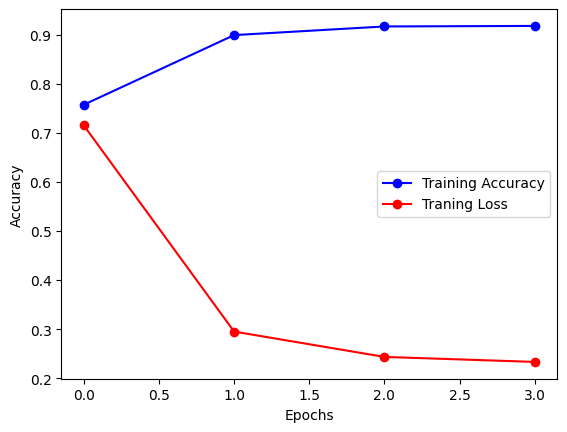

In [20]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc,'-ob',label = 'Training Accuracy')
#plt.figure()
plt.plot(loss,'-or', label = 'Traning Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend();


## Saving the Model

In [50]:
# Save the trained model
model.save('./your_models_trained/animals_EfficientNetB0.h5')

# You can reuse the model trained in other project

## Loading the Model

In [20]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('./your_models_trained/animals_EfficientNetB0.h5')

### Example how to use the model

In [23]:
def predict_animal_species(image_name: str):
    """
    Predict the species of an animal from an image file.

    This function uses a pre-trained EfficientNet model to predict the likelihood
    of an animal belonging to several species categories, given the path to an image.
    
    Args:
        image_name (str): The name of the image file located in the './image_tests/' directory.

    Returns:
        dict: A dictionary with species names as keys and their corresponding prediction
              probabilities (floats between 0 and 1) as values.

    Example:
        >>> output = predict_animal_species("sample_image.jpg")
        >>> print(output)
        {
            'birds': 0.10,
            'cats': 0.70,
            'dogs': 0.05,
            'fishs': 0.02,
            'hamsters': 0.01,
            'monkeys': 0.03,
            'reptiles': 0.09
        }

    Notes:
        - The image is resized to 224x224 pixels to match the EfficientNet model's input size.
        - Image normalization is applied using the EfficientNet preprocessing method.
        - Ensure that the model is loaded and compiled before using this function.
    """
    # Open Image
    sample_image = tf.keras.preprocessing.image.load_img(r'./image_tests/' + str(image_name),
                                                    target_size=(224,224))
    plt.imshow(sample_image)
    # Img to Array
    sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
    # Put in the format (1,224,224,3)
    sample_image = np.expand_dims(sample_image,axis=0)
    # Normalise according to the Resnet50
    sample_image = tf.keras.applications.efficientnet.preprocess_input(sample_image)
    # predictions
    predictions = model.predict(sample_image)
        
    output = {
        'birds':   predictions[0][0],
        'cats':    predictions[0][1],
        'dogs':    predictions[0][2],
        'fishs':   predictions[0][3],
        'hamsters':predictions[0][4],
        'monkeys': predictions[0][5],
        'reptiles':predictions[0][6],
    }
    return output


## Testing model

{'birds': 0.9997619,
 'cats': 1.7267769e-07,
 'dogs': 9.313074e-05,
 'fishs': 6.988846e-05,
 'hamsters': 5.1529965e-05,
 'monkeys': 3.14099e-06,
 'reptiles': 2.0526311e-05}

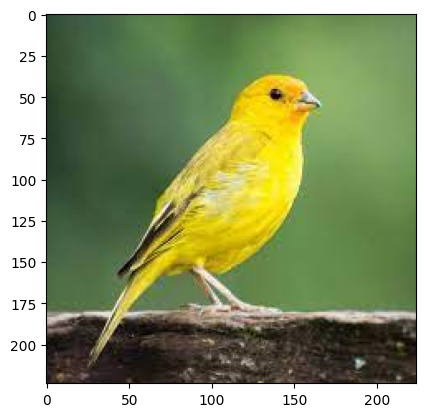

In [24]:
predict_animal_species('canario.jpg')

{'birds': 0.0005460728,
 'cats': 5.8921803e-05,
 'dogs': 0.00069967005,
 'fishs': 0.00014801911,
 'hamsters': 0.00016831666,
 'monkeys': 0.0005848173,
 'reptiles': 0.99779415}

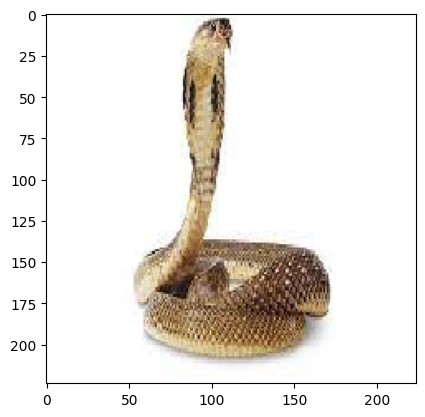

In [23]:
predict_animal_species('cobra.jpg')

{'birds': 5.8375516e-10,
 'cats': 1.6004306e-10,
 'dogs': 4.7127507e-08,
 'fishs': 4.017219e-09,
 'hamsters': 2.9032905e-09,
 'monkeys': 1.0,
 'reptiles': 4.3756698e-10}

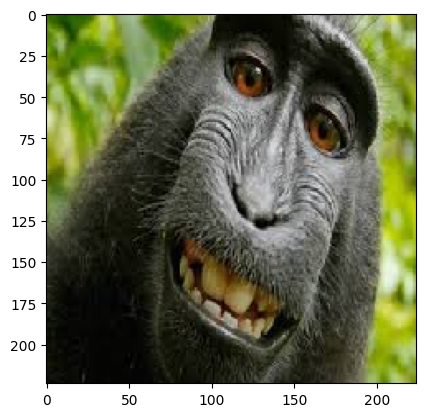

In [24]:
predict_animal_species('macaco1.jpeg')

{'birds': 1.0926297e-10,
 'cats': 2.428367e-10,
 'dogs': 1.2972139e-07,
 'fishs': 1.2219205e-08,
 'hamsters': 1.4916286e-10,
 'monkeys': 0.9999999,
 'reptiles': 3.5479394e-11}

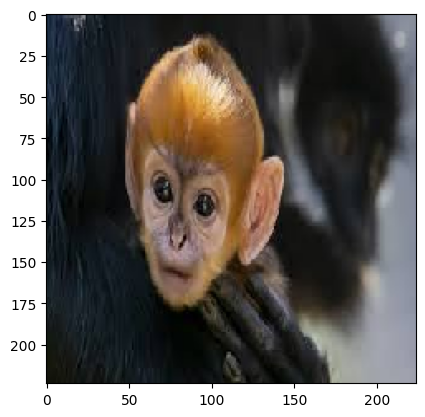

In [25]:
predict_animal_species('macaco2.jpeg')

{'birds': 1.3658731e-12,
 'cats': 6.517161e-12,
 'dogs': 6.9285133e-09,
 'fishs': 1.1944375e-11,
 'hamsters': 2.6737156e-11,
 'monkeys': 1.0,
 'reptiles': 3.8377504e-12}

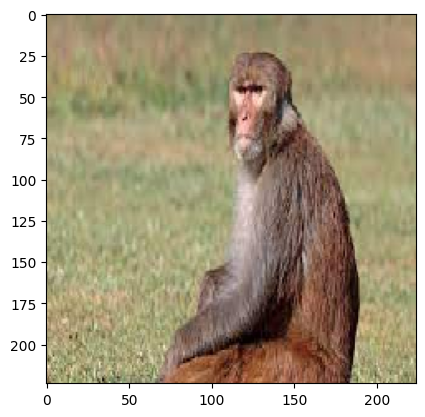

In [26]:
predict_animal_species('macaco.jpeg')

{'birds': 0.99998677,
 'cats': 6.895815e-10,
 'dogs': 8.7973814e-07,
 'fishs': 8.965982e-06,
 'hamsters': 3.3768767e-06,
 'monkeys': 9.764908e-08,
 'reptiles': 5.8039298e-08}

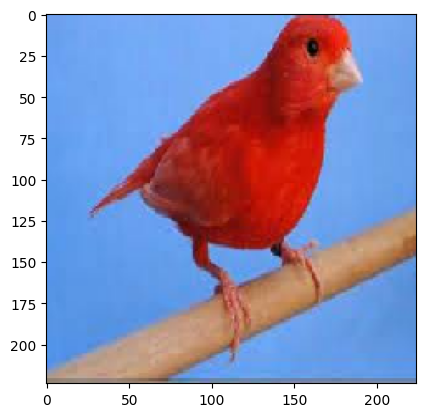

In [27]:
predict_animal_species('canario1.jpg')

{'birds': 0.9999478,
 'cats': 4.2246082e-08,
 'dogs': 2.9490622e-05,
 'fishs': 8.817302e-06,
 'hamsters': 1.2792435e-05,
 'monkeys': 4.8506445e-07,
 'reptiles': 7.212807e-07}

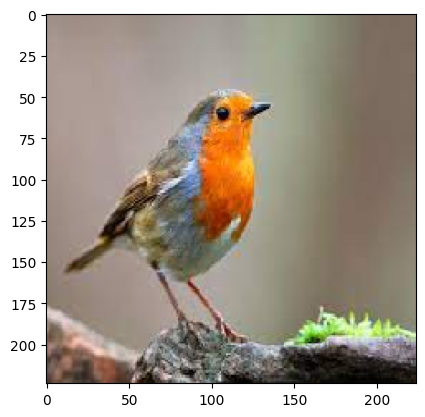

In [28]:
predict_animal_species('birds.2.jpg')

{'birds': 7.3753754e-06,
 'cats': 3.8514767e-07,
 'dogs': 0.9999819,
 'fishs': 3.012416e-07,
 'hamsters': 1.056828e-06,
 'monkeys': 7.87502e-06,
 'reptiles': 1.068145e-06}

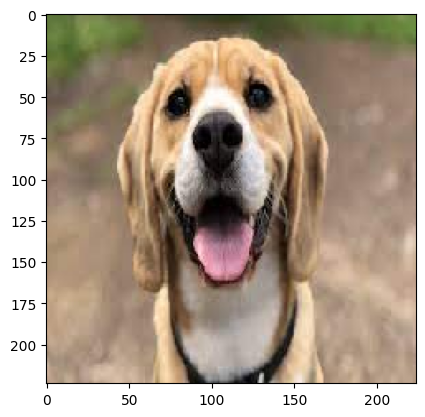

In [29]:
predict_animal_species('dog99.jpeg')

{'birds': 0.00053616957,
 'cats': 2.7745955e-05,
 'dogs': 0.0032881366,
 'fishs': 0.0025228118,
 'hamsters': 4.8113474e-05,
 'monkeys': 0.00044301013,
 'reptiles': 0.993134}

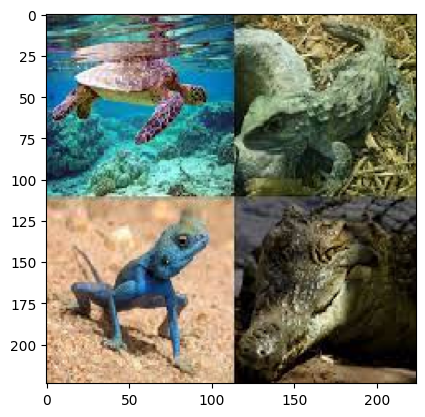

In [30]:
predict_animal_species('reptiles.0.jpg')

{'birds': 7.424732e-05,
 'cats': 0.9985812,
 'dogs': 0.001187132,
 'fishs': 1.5218899e-05,
 'hamsters': 2.0403802e-05,
 'monkeys': 5.3368643e-05,
 'reptiles': 6.839377e-05}

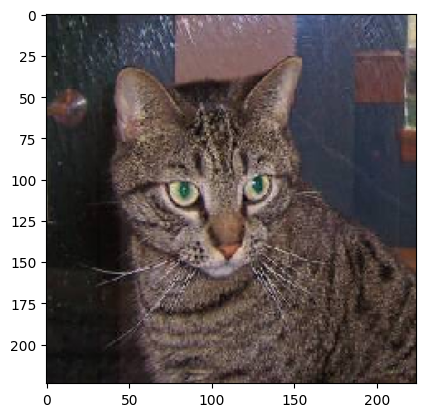

In [31]:
predict_animal_species('cat.1.jpg')

{'birds': 3.4533425e-06,
 'cats': 2.3262083e-07,
 'dogs': 0.99998486,
 'fishs': 6.6031666e-06,
 'hamsters': 1.3036426e-06,
 'monkeys': 1.1070648e-06,
 'reptiles': 2.4920457e-06}

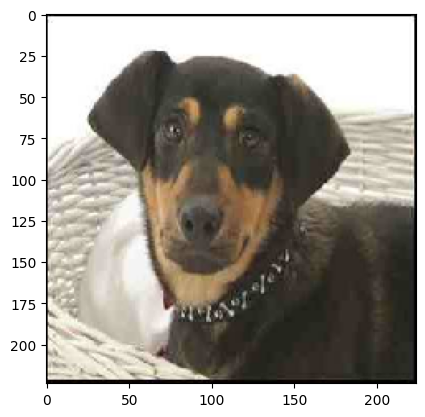

In [32]:
predict_animal_species('dog.jpg')

{'birds': 3.7333633e-05,
 'cats': 0.99926585,
 'dogs': 0.00064946216,
 'fishs': 1.065861e-05,
 'hamsters': 1.231519e-05,
 'monkeys': 2.119748e-05,
 'reptiles': 3.3102954e-06}

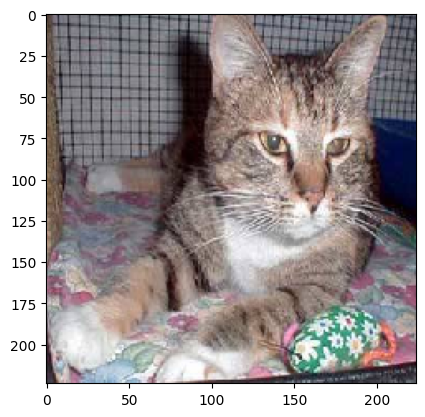

In [33]:
predict_animal_species('gato.jpg')

{'birds': 0.00013397625,
 'cats': 3.9902996e-05,
 'dogs': 0.001605508,
 'fishs': 0.002301177,
 'hamsters': 0.0001589324,
 'monkeys': 0.0005511089,
 'reptiles': 0.9952094}

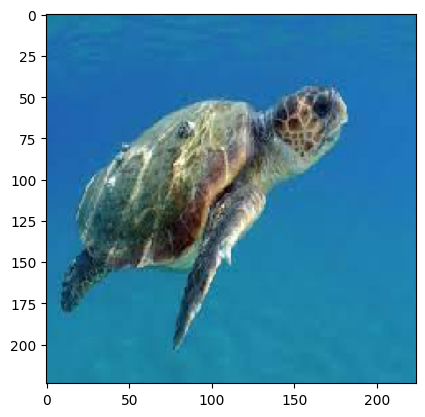

In [34]:
predict_animal_species('tartaruga.jpg')

{'birds': 4.3115497e-06,
 'cats': 9.8774734e-08,
 'dogs': 1.8192255e-06,
 'fishs': 0.99993753,
 'hamsters': 4.055101e-05,
 'monkeys': 6.3000516e-07,
 'reptiles': 1.5154222e-05}

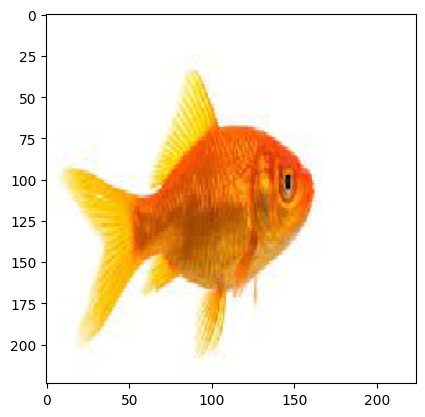

In [35]:
predict_animal_species('fish.jpeg')

## Testing the model with species it was not trained on

{'birds': 0.000161445,
 'cats': 0.00021147158,
 'dogs': 0.0002898081,
 'fishs': 0.118318364,
 'hamsters': 0.00048815765,
 'monkeys': 0.00018901889,
 'reptiles': 0.8803417}

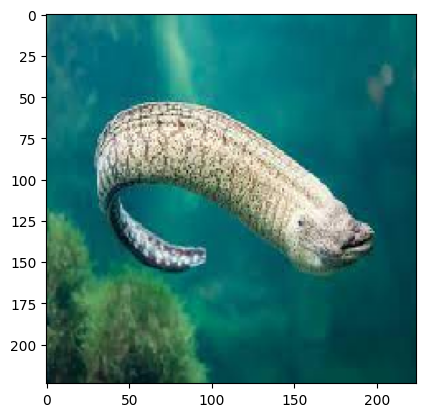

In [36]:
predict_animal_species('moreia.jpeg')

{'birds': 0.0020120046,
 'cats': 0.00031282476,
 'dogs': 0.9881986,
 'fishs': 0.0007026706,
 'hamsters': 0.0013476326,
 'monkeys': 0.0038827425,
 'reptiles': 0.0035434999}

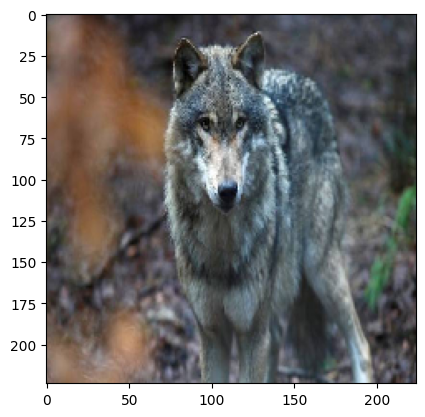

In [37]:
predict_animal_species('lobo.jpg')

{'birds': 3.6287656e-06,
 'cats': 8.304058e-07,
 'dogs': 0.9991716,
 'fishs': 6.9532706e-07,
 'hamsters': 3.8434578e-06,
 'monkeys': 0.000817748,
 'reptiles': 1.8273241e-06}

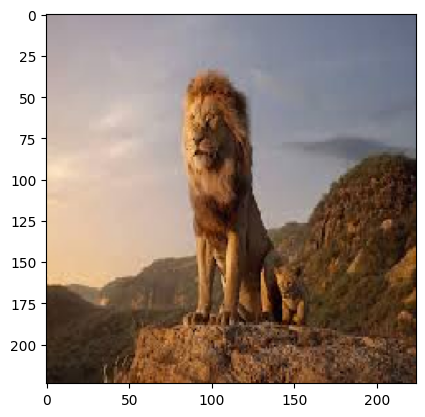

In [38]:
predict_animal_species('leao.jpg')

{'birds': 1.5344129e-05,
 'cats': 0.0021675497,
 'dogs': 0.9967097,
 'fishs': 5.88347e-05,
 'hamsters': 0.0006045643,
 'monkeys': 0.0003388095,
 'reptiles': 0.00010519884}

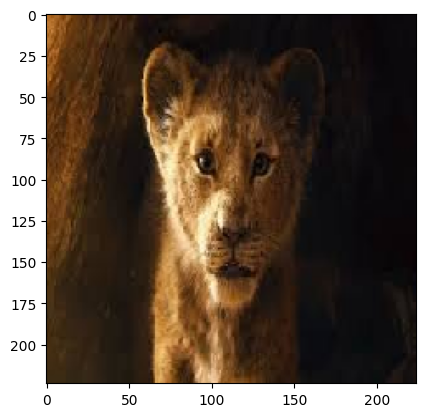

In [39]:
predict_animal_species('filhote_leao.jpg') # Entendeu 63% gato

{'birds': 0.011126349,
 'cats': 0.08862518,
 'dogs': 0.41250858,
 'fishs': 0.021527508,
 'hamsters': 0.013734271,
 'monkeys': 0.4472778,
 'reptiles': 0.005200241}

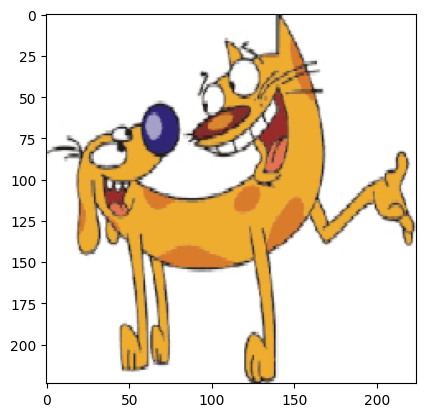

In [40]:
predict_animal_species('catdog.png')

{'birds': 0.09163007,
 'cats': 0.0037659574,
 'dogs': 0.44755712,
 'fishs': 0.34299257,
 'hamsters': 0.037896767,
 'monkeys': 0.07303508,
 'reptiles': 0.0031224205}

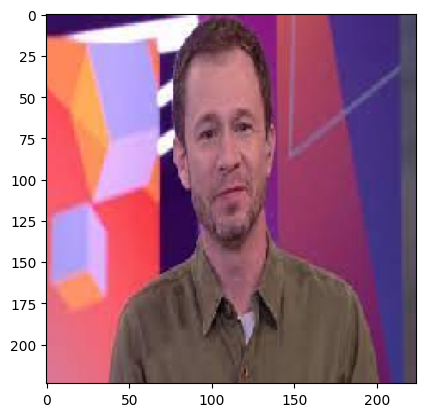

In [41]:
predict_animal_species('homem2.jpeg')

{'birds': 7.642997e-05,
 'cats': 1.0080221e-05,
 'dogs': 5.6071126e-06,
 'fishs': 3.4488312e-05,
 'hamsters': 5.9786896e-07,
 'monkeys': 1.6007984e-06,
 'reptiles': 0.99987113}

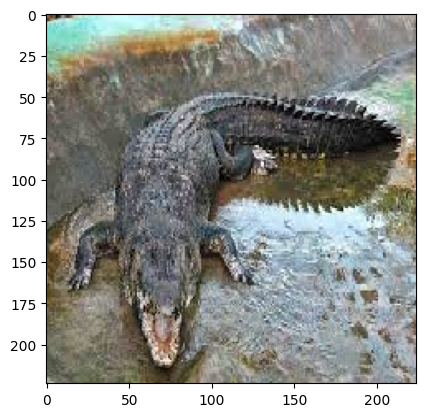

In [42]:
predict_animal_species('croc.jpeg')

{'birds': 7.174397e-05,
 'cats': 0.9853337,
 'dogs': 0.013556248,
 'fishs': 6.521035e-05,
 'hamsters': 0.0008827825,
 'monkeys': 8.828052e-05,
 'reptiles': 1.913886e-06}

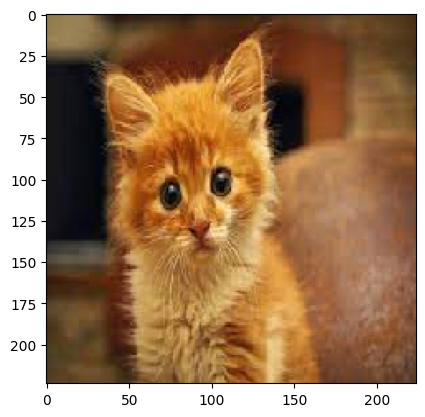

In [54]:
predict_animal_species('gatinho.jpeg')

## Lite Model - Converting to Lite Version

In [1]:
import tensorflow as tf

# Carregar o modelo original .h5 e redefinir o tamanho de entrada
model = tf.keras.models.load_model('./your_models_trained/animals_EfficientNetB0.h5')

# Redefinir o tamanho de entrada para fixar [1, 224, 224, 3]
new_input = tf.keras.layers.Input(shape=(224, 224, 3))
new_output = model(new_input)
model_fixed = tf.keras.models.Model(inputs=new_input, outputs=new_output)

# Converter para TFLite novamente com o tamanho de entrada fixo
converter = tf.lite.TFLiteConverter.from_keras_model(model_fixed)
tflite_model_fixed = converter.convert()

# Salvar o novo modelo TFLite
with open('./your_models_trained/animals_EfficientNetB0.tflite', 'wb') as f:
    f.write(tflite_model_fixed)



2024-10-27 11:42:40.810091: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-10-27 11:43:01.732284: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/miguel2019ubuntu/Projects/Machine_Learning/train_your_classifier/env/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmposeyj087/assets


2024-10-27 11:43:26.685069: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-10-27 11:43:26.685354: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-10-27 11:43:26.686146: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2194850000 Hz
2024-10-27 11:43:26.723018: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.017ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2024-10-27 11:43:29.747946: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2024-10-27 11:43:29.747977: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2024-10-27 11:43:29.91530

In [2]:
# Carregar o modelo TFLite corrigido
interpreter = tf.lite.Interpreter(model_path='./your_models_trained/animals_EfficientNetB0.tflite')
interpreter.allocate_tensors()

# Obtenha detalhes de entrada e saída
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Verificar o shape de entrada e o tipo de dados
print("Novo input shape esperado:", input_details[0]['shape'])
print("Novo input dtype esperado:", input_details[0]['dtype'])


Novo input shape esperado: [  1 224 224   3]
Novo input dtype esperado: <class 'numpy.float32'>


## Loading Model

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Carregar o modelo TFLite com o shape de entrada fixo
interpreter = tf.lite.Interpreter(model_path='./your_models_trained/animals_EfficientNetB0.tflite')
interpreter.allocate_tensors()

## Function to Predict

In [4]:

def predict_animal_species(image_name: str):
    """
    Predict the species of an animal from an image file using TFLite.
    
    Args:
        image_name (str): Nome do arquivo da imagem na pasta './image_tests/'.

    Returns:
        dict: Um dicionário com nomes de espécies como chaves e as probabilidades de predição como valores.
    """
    # Carregar e preparar a imagem
    sample_image = tf.keras.preprocessing.image.load_img(f'./image_tests/{image_name}', target_size=(224, 224))
    plt.imshow(sample_image)

    # Converter a imagem para array e expandir dimensões
    sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
    sample_image = np.expand_dims(sample_image, axis=0).astype(np.float32)

    # Pré-processar a imagem para o EfficientNet
    sample_image = tf.keras.applications.efficientnet.preprocess_input(sample_image)

    # Definir a imagem como entrada para o modelo TFLite
    interpreter.set_tensor(input_details[0]['index'], sample_image)
    
    # Rodar a inferência
    interpreter.invoke()

    # Extrair os resultados da inferência
    predictions = interpreter.get_tensor(output_details[0]['index'])

    # Formatar a saída como dicionário
    output = {
        'birds':   predictions[0][0],
        'cats':    predictions[0][1],
        'dogs':    predictions[0][2],
        'fishs':   predictions[0][3],
        'hamsters':predictions[0][4],
        'monkeys': predictions[0][5],
        'reptiles':predictions[0][6],
    }
    return output



{'birds': 7.174472e-05,
 'cats': 0.9853336,
 'dogs': 0.013556363,
 'fishs': 6.521103e-05,
 'hamsters': 0.00088279124,
 'monkeys': 8.82816e-05,
 'reptiles': 1.913904e-06}

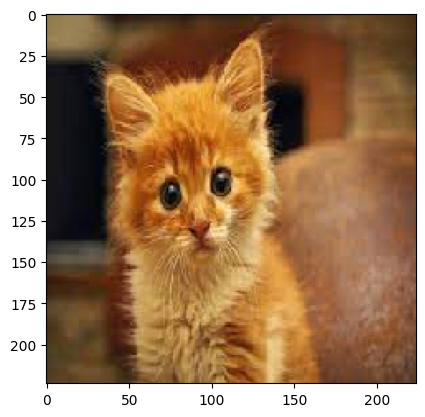

In [5]:
predict_animal_species('gatinho.jpeg')

{'birds': 0.011126251,
 'cats': 0.088625506,
 'dogs': 0.41250926,
 'fishs': 0.021527302,
 'hamsters': 0.013734207,
 'monkeys': 0.4472771,
 'reptiles': 0.0052002277}

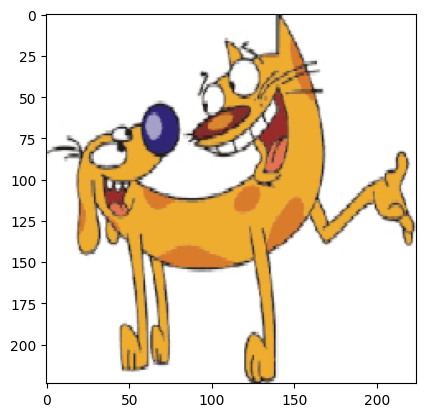

In [6]:
predict_animal_species('catdog.png')